In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from counterfactuals.datasets import DigitsDataset
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    MultilayerPerceptron,
)
from counterfactuals.metrics import CFMetrics

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [169]:
dataset = DigitsDataset("../data/digits.csv")

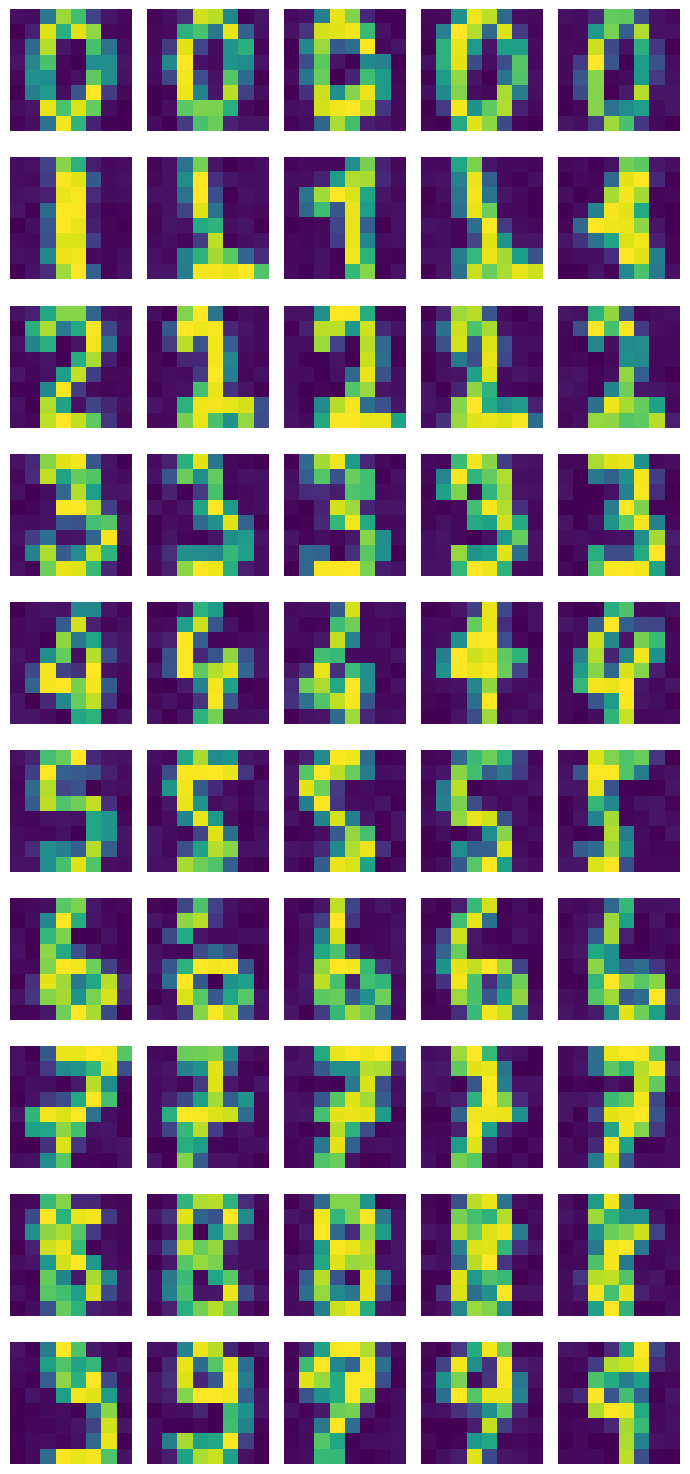

In [4]:
fig, axes = plt.subplots(10, 5, figsize=(7, 15))

for class_label in range(10):
    class_indices = np.where(np.argmax(dataset.y_train, axis=1) == class_label)[0]
    random_indices = np.random.choice(class_indices, 5, replace=False)

    for i, idx in enumerate(random_indices):
        ax = axes[class_label, i]
        samples = dataset.X_train[idx].reshape(8, 8)
        samples = DigitsDataset.inverse_transform(samples)
        ax.imshow(samples)
        ax.axis("off")
        if i == 0:
            ax.set_ylabel(f"Class {class_label}", rotation=0, labelpad=20, size="large")

plt.tight_layout()
plt.show()

In [7]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 10, device="mps")
disc_model.to("mps")
disc_model.fit(
    dataset.train_dataloader(batch_size=128, shuffle=True, noise_lvl=0.003),
    dataset.test_dataloader(batch_size=128, shuffle=False),
    epochs=100,
    patience=100,
    lr=3e-4,
    checkpoint_path="mnist_disc_model.pt",
)
# disc_model.load("disc_model.pt")

  0%|          | 0/100 [00:00<?, ?it/s]/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to th

In [8]:
disc_model.to("cpu")

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (final_activation): Softmax(dim=1)
  (criterion): CrossEntropyLoss()
)

In [9]:
# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=256, shuffle=True),
#     dataset.test_dataloader(batch_size=256, shuffle=False),
#     epochs=5000,
#     patience=100,
#     checkpoint_path="disc_model.pt",
# )
# # disc_model.load("disc_model.pt")

In [11]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == np.argmax(dataset.y_test, axis=1)).mean())

Test accuracy: 0.9750889679715302


In [14]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [12]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=256,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=10,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
    device="cpu",
)
train_dataloader = dataset.train_dataloader(
    batch_size=128, shuffle=True, noise_lvl=0.003
)
# train_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)
test_dataloader = dataset.test_dataloader(batch_size=2048, shuffle=False)

gen_model.fit(
    train_dataloader,
    test_dataloader,
    learning_rate=1e-4,
    patience=30,
    num_epochs=500,
    checkpoint_path="flow.pth",
)
# # gen_model.load("flow.pth")

Epoch 60, Train: 1.8618, test: 2.3325, patience: 30:  12%|█▏        | 60/500 [00:41<05:01,  1.46it/s]
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf/maf.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an

In [13]:
input = torch.tensor(dataset.X_train, dtype=torch.float32)
labels = torch.tensor(dataset.y_train, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    output = -gen_model(input, labels).mean()
    print(output)


input = torch.tensor(dataset.X_test, dtype=torch.float32)
labels = torch.tensor(dataset.y_test, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    output = -gen_model(input, labels).mean()
    print(output)

tensor(90.9194)
tensor(101.9157)


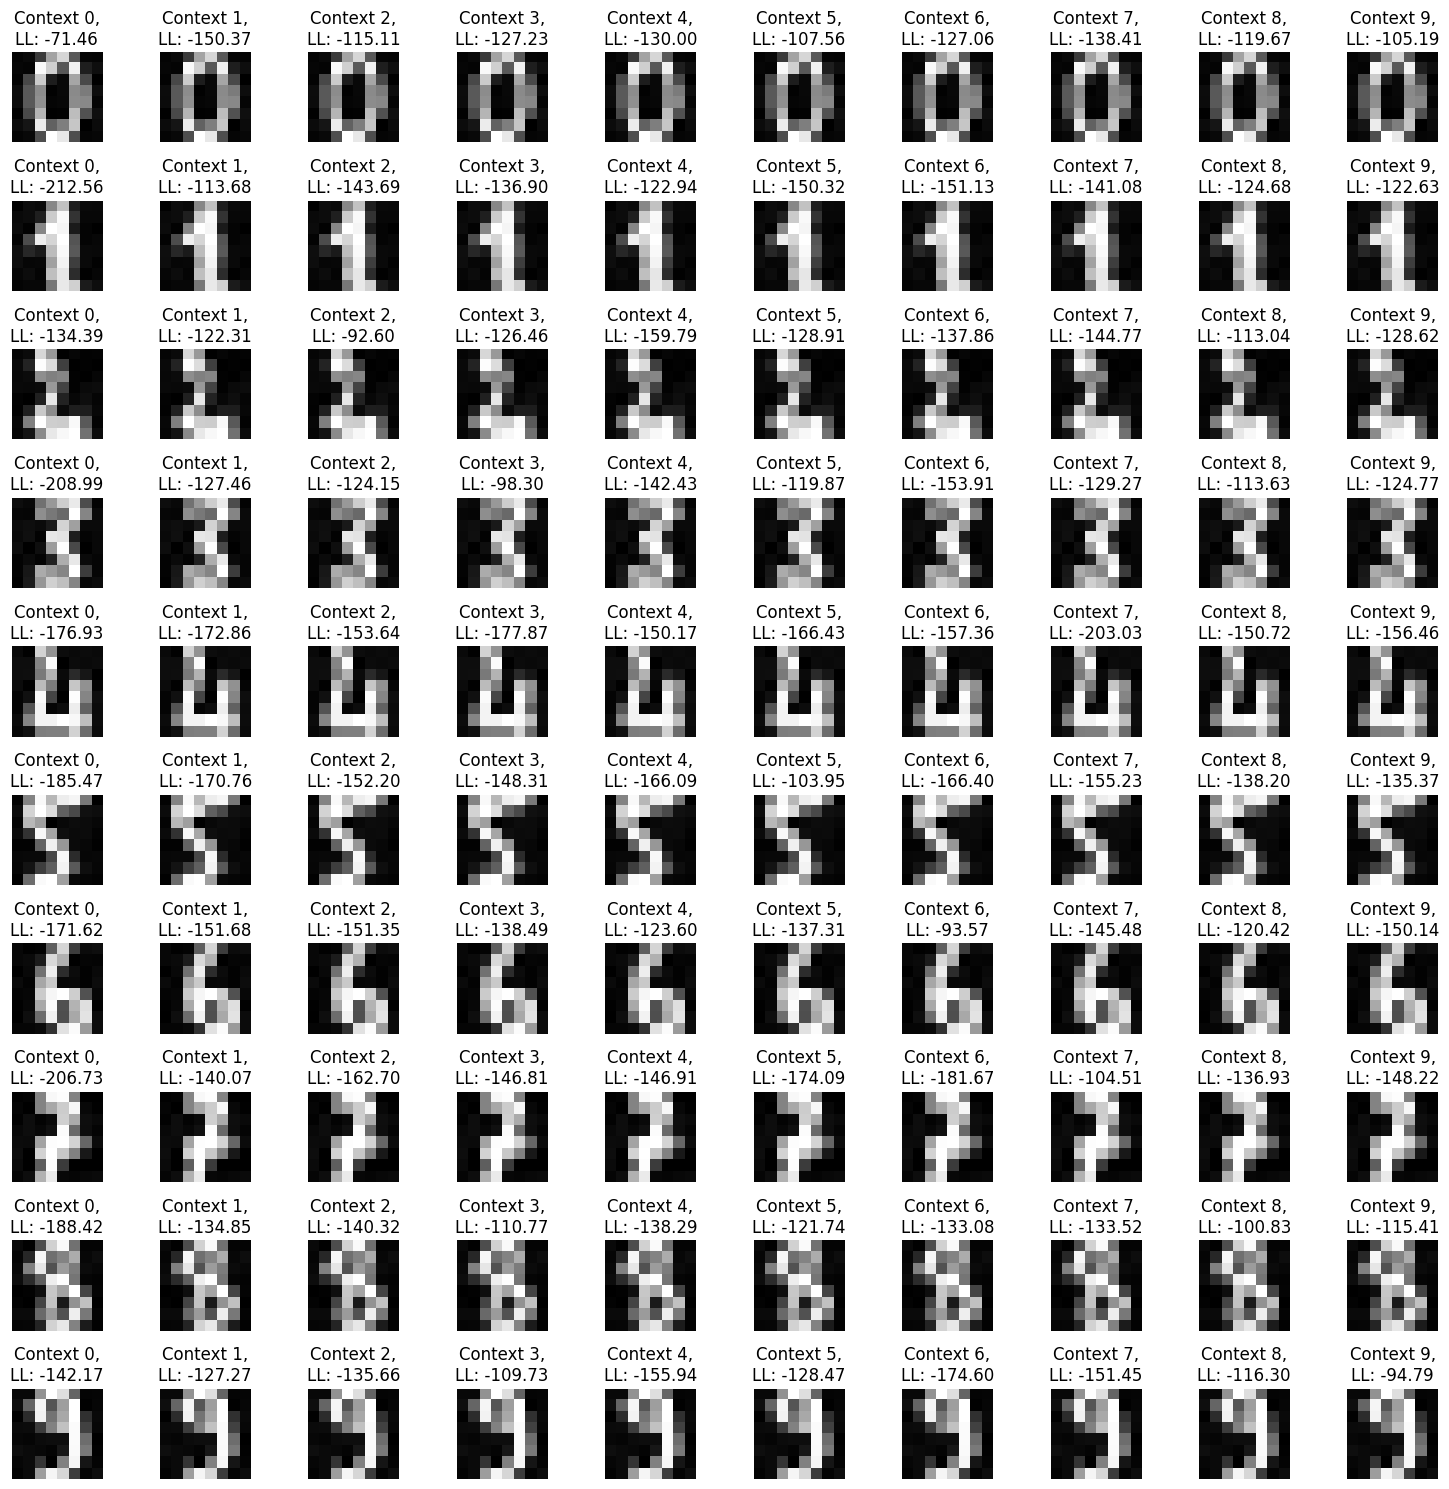

In [18]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for i in range(10):
    for context in range(10):
        input = torch.tensor(
            dataset.X_test[np.argmax(dataset.y_test, axis=1) == i][0],
            dtype=torch.float32,
        )
        with torch.no_grad():
            context_t = torch.tensor([np.eye(10)[context]]).view(-1, 10).float()
            input = input.view(1, -1)
            gen_model.eval()
            output = gen_model(input, context_t).detach().numpy()
        ax = axes[i, context]
        ax.imshow(
            DigitsDataset.inverse_transform(input.numpy().reshape(8, 8)), cmap="gray"
        )
        ax.set_title(f"Context {context},\nLL: {output.item():.2f}")
        ax.axis("off")

plt.tight_layout()
plt.show()

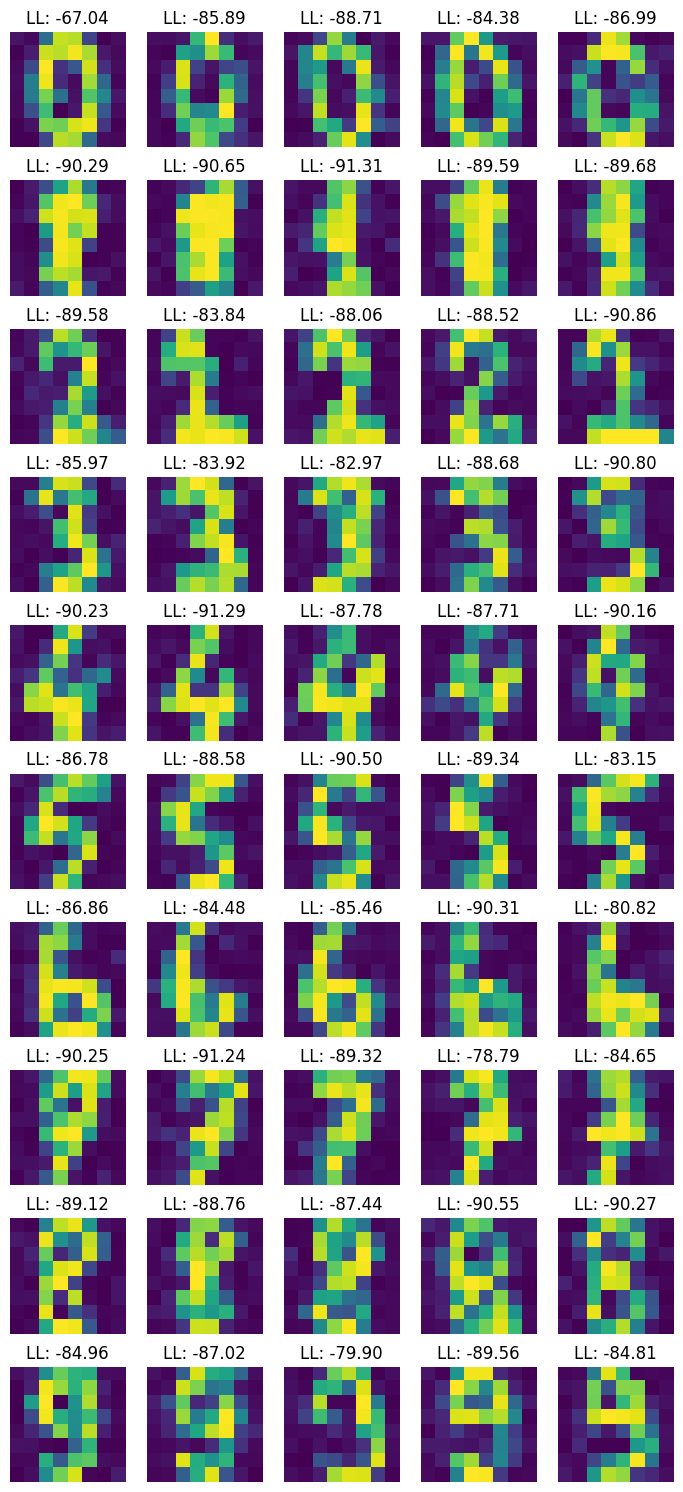

In [ ]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.5,
)

fig, axes = plt.subplots(10, 5, figsize=(7, 15))

for class_label in range(10):
    context_t = torch.tensor([np.eye(10)[class_label]]).view(-1, 10).float()
    generated_images, ll = gen_model.sample_and_log_prob(100, context=context_t)
    high_prob_indices = (ll[0] > log_prob_threshold).nonzero(as_tuple=True)[0]
    selected_indices = np.random.choice(high_prob_indices, 5, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = axes[class_label, i]
        samples = generated_images[0][idx].view(8, 8).detach().numpy()
        samples = DigitsDataset.inverse_transform(samples)
        ax.imshow(samples)
        ax.set_title(f"LL: {ll[0][idx].item():.2f}")
        ax.axis("off")
        if i == 0:
            ax.set_ylabel(f"Class {class_label}", rotation=0, labelpad=20, size="large")

plt.tight_layout()
plt.show()

In [170]:
source_class = 9
target_class = 0
X_test_origin = dataset.X_test[np.argmax(dataset.y_test, axis=1) == source_class]
y_test_origin = dataset.y_test[np.argmax(dataset.y_test, axis=1) == source_class]

In [181]:
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=4,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(eps=0.1),
    actionable_features=None,
    neptune_run=None,
)

In [182]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    target_class=target_class,
    epochs=20000,
    lr=0.01,
    patience=1000,
    alpha_dist=1e-3,
    alpha_plaus=10**3,
    alpha_class=10**5,
    alpha_s=10**3,
    alpha_k=10**1,
    log_prob_threshold=log_prob_threshold,
)

loss: 17106.0605, dist: 0.0568, max_inner: 17055.6895, loss_disc: 0.0000, delta_loss: 50.3719:  66%|██████▌   | 13101/20000 [02:54<01:32, 74.96it/s]      


In [183]:
M, S, D = delta.get_matrices()

In [184]:
S.sum(axis=0)

tensor([ 7.3055, 52.4133, 49.2812,  3.0000], grad_fn=<SumBackward1>)

In [185]:
values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

Correct: 101/112
4


In [186]:
Xs_cfs = Xs + delta().detach().numpy()

In [187]:
y_pred = disc_model.predict(Xs_cfs).detach().numpy().flatten()
# print("Test accuracy:", (y_pred == ys_target).mean())
print("Test accuracy:", (y_pred == np.argmax(ys_target, axis=1)).mean())

Test accuracy: 1.0


In [188]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.01,
)

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)

In [189]:
metrics.calc_all_metrics()

{'coverage': 1.0,
 'validity': 0.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 11.626553217914594,
 'proximity_continuous_manhattan': 56.822465907132155,
 'proximity_continuous_euclidean': 11.626553217914594,
 'proximity_continuous_mad': 41.64669882399695,
 'proximity_l2_jaccard': 11.626553217914594,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.5089285714285714,
 'log_density_cf': -113.38686,
 'log_density_test': -103.72799,
 'lof_scores_cf': 1.2334366,
 'lof_scores_test': 1.0472971,
 'isolation_forest_scores_cf': 0.07247195822748295,
 'isolation_forest_scores_test': 0.07607442620918911}

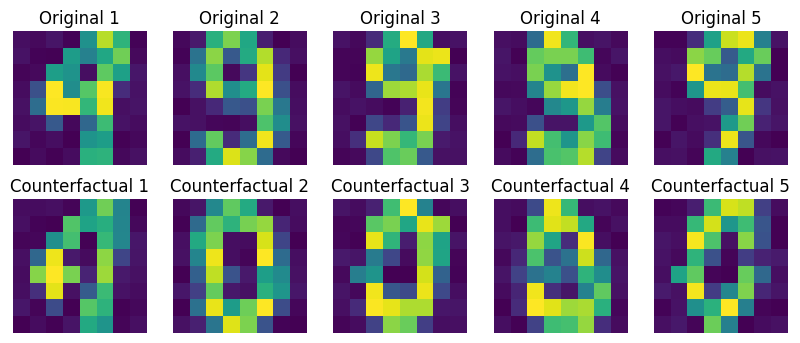

In [195]:
X_test_origin, Xs_cfs
random_indices = np.random.choice(len(X_test_origin), 5, replace=False)

plt.figure(figsize=(10, 4))

for i, idx in enumerate(random_indices):
    # Plot original image
    plt.subplot(2, 5, i + 1)
    original_image = DigitsDataset.inverse_transform(X_test_origin[idx].reshape(8, 8))
    plt.imshow(original_image)
    plt.title(f"Original {i+1}")
    plt.axis("off")

    # Plot counterfactual image
    plt.subplot(2, 5, i + 6)
    cf_image = DigitsDataset.inverse_transform(Xs_cfs[idx].reshape(8, 8))
    plt.imshow(cf_image)
    plt.title(f"Counterfactual {i+1}")
    plt.axis("off")

plt.show()

# TODO
1. Wziąć duo więcej próbek
2. Bez grupowych spróbować
3. Grupowe bez triku
3. Poprawić dekwantyzacje (nie powinno tak być)
4. Przeanalizować ręcznie LOF oraz IsoForest (czy działa na obrazkach)
4.5 IsoForest - zrobić głębokie drzewa

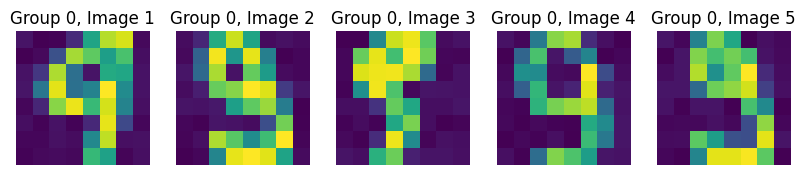

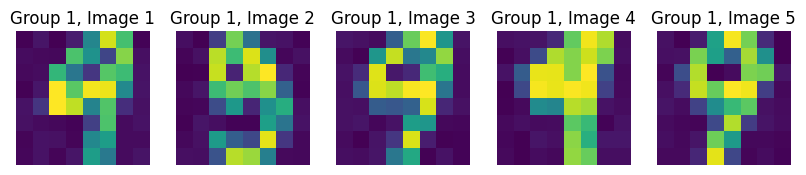

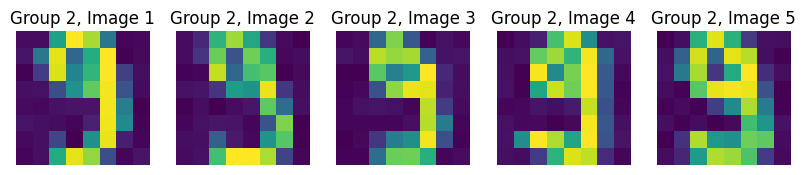

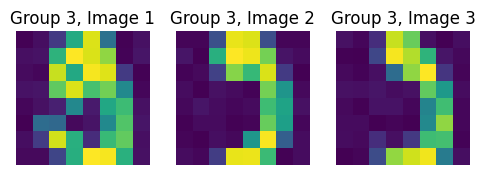

In [196]:
unique_groups = torch.unique(S.argmax(dim=1))

for group in unique_groups:
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    num_images = min(5, len(group_indices))
    selected_indices = group_indices[:num_images]

    plt.figure(figsize=(10, 2 * num_images))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(DigitsDataset.inverse_transform(X_test_origin[idx].reshape(8, 8)))
        plt.title(f"Group {group.item()}, Image {i+1}")
        plt.axis("off")
    plt.show()

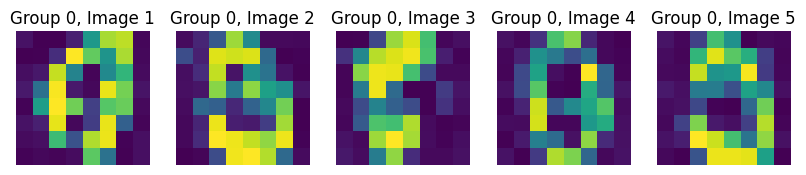

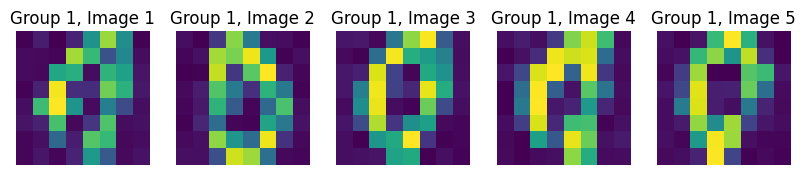

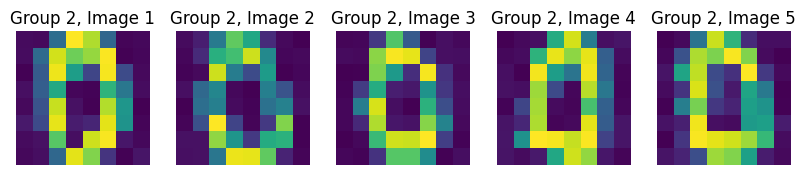

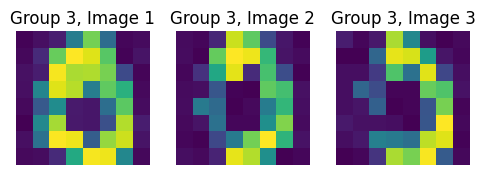

In [197]:
unique_groups = torch.unique(S.argmax(dim=1))

for group in unique_groups:
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    num_images = min(5, len(group_indices))
    selected_indices = group_indices[:num_images]

    plt.figure(figsize=(10, 2 * num_images))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(DigitsDataset.inverse_transform(Xs_cfs[idx].reshape(8, 8)))
        plt.title(f"Group {group.item()}, Image {i+1}")
        plt.axis("off")
    plt.show()

In [124]:
# # pickle delta object
# import pickle

# with open("digits38/delta.pkl", "wb") as f:
#     pickle.dump(delta, f)

# with open("digits38/Xs_cfs.pkl", "wb") as f:
#     pickle.dump(Xs_cfs, f)

# with open("digits38/X_test_origin.pkl", "wb") as f:
#     pickle.dump(X_test_origin, f)

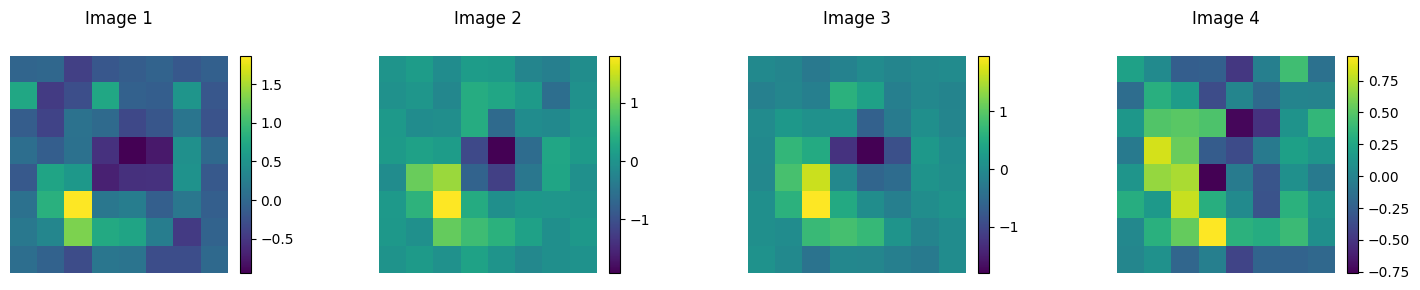

In [198]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

for i in range(4):
    ax = axes[i]
    image = D[i].reshape(8, 8).detach().numpy()
    cax = ax.matshow(image, cmap="viridis")
    ax.set_title(f"Image {i+1}")
    ax.axis("off")
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

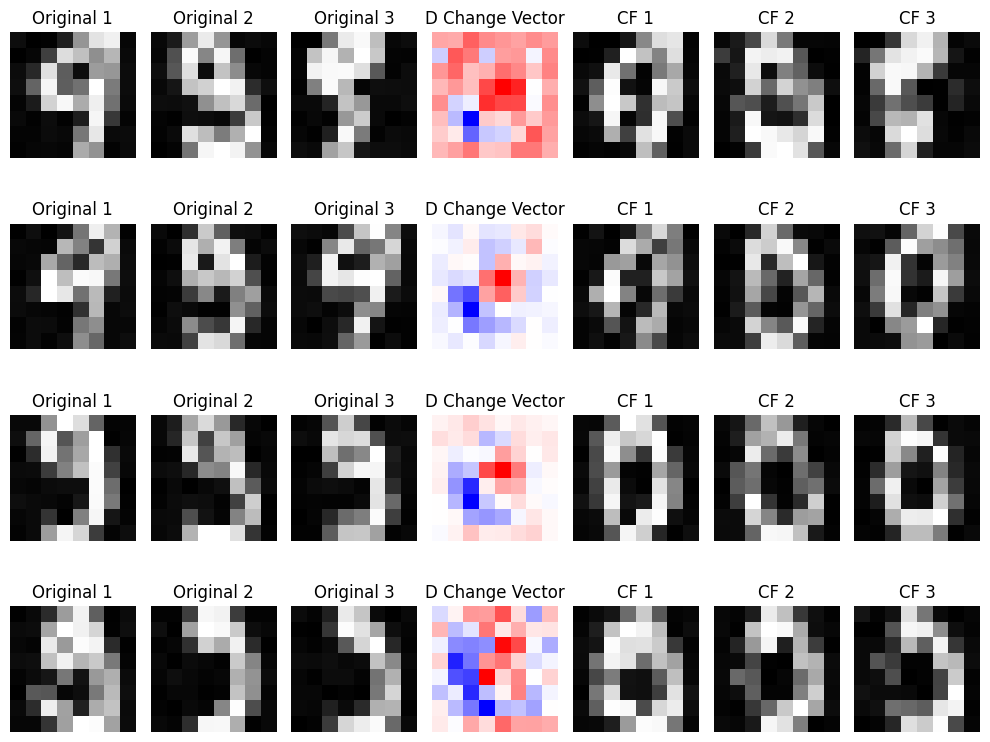

In [215]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming X_test_origin, Xs_cfs, D, and S are already defined
unique_groups = torch.unique(S.argmax(dim=1))
num_images = 3
fig, axes = plt.subplots(
    len(unique_groups), 2 * num_images + 1, figsize=(10, 8)
)  # 3 original, 1 D, 3 counterfactual

for group_i, group in enumerate(unique_groups):
    # Get indices for the current group
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    # num_images = min(3, len(group_indices))  # Limit to 3 images per group
    selected_indices = group_indices[:num_images]

    # Create a figure to display the images
    axes[group_i, num_images].imshow(
        D[group_i].reshape(8, 8).detach().numpy(), cmap="bwr_r"
    )
    axes[group_i, num_images].set_title("D Change Vector")
    axes[group_i, num_images].axis("off")

    for i, idx in enumerate(selected_indices):
        # Original images on the left
        axes[group_i, i].imshow(
            DigitsDataset.inverse_transform(X_test_origin[idx].reshape(8, 8)),
            cmap="gray",
        )
        axes[group_i, i].set_title(f"Original {i+1}")
        axes[group_i, i].axis("off")

        # Counterfactual images on the right
        axes[group_i, i + num_images + 1].imshow(
            DigitsDataset.inverse_transform(Xs_cfs[idx].reshape(8, 8)), cmap="gray"
        )
        axes[group_i, i + num_images + 1].set_title(f"CF {i+1}")
        axes[group_i, i + num_images + 1].axis("off")

plt.tight_layout()
plt.show()